In [13]:
#importing useful packages and modules
import numpy as np
import gala.potential as gp
from gala.units import galactic, solarsystem
import astropy.units as u
from astropy.coordinates.matrix_utilities import rotation_matrix
import astropy.coordinates as coord
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import matplotlib as mpl
import galstreams
from mpl_toolkits.mplot3d import Axes3D


from gala.dynamics import mockstream as ms
from matplotlib import pyplot as plt
_ = coord.galactocentric_frame_defaults.set('v4.0')

# Setting bar & no bar MW Potentials

In [14]:
#MW Potential- bar, bulge

disk = gp.MiyamotoNagaiPotential(m=1E11, a=6.5, b=0.27, units=galactic)
halo = gp.NFWPotential(m=5E11,r_s=18,b=0.94,units=galactic) #is b = q in Pearson et al.2017??
bulge = gp.HernquistPotential(m=3E10, c=0.7, units=galactic)

bar_static= gp.LongMuraliBarPotential(m=1E10, a=3.5,b=0.5,c=0.5,alpha=-27*u.deg,units=galactic)# parameters from gala

#specifying rotation
R_array = rotation_matrix(60*u.deg, 'z')
bar_dynamic = gp.LongMuraliBarPotential(m=1E10, a=3.5,b=0.5,c=0.5,alpha=-27*u.deg,units=galactic,R=R_array)

pot2_static = gp.CCompositePotential(disk=disk,halo=halo,bulge=bulge,bar=bar_static)
pot2_dynamic= gp.CCompositePotential(disk=disk,halo=halo,bulge=bulge,bar=bar_dynamic)

In [15]:
#MW Potential- no bar, bulge

disk = gp.MiyamotoNagaiPotential(m=1E11, a=6.5, b=0.27, units=galactic)
halo = gp.NFWPotential(m=5E11,r_s=18,b=0.94,units=galactic) #is b = q in Pearson et al.2017??
bulge = gp.HernquistPotential(m=3E10, c=0.7, units=galactic)


pot3 = gp.CCompositePotential(disk=disk,halo=halo,bulge=bulge)

In [16]:
xyz = np.zeros((3, 1024))
xyz[0] = np.linspace(0, 25, xyz.shape[1])

np.where( (xyz[0]>7.99) & (xyz[0]<8.01))

(array([327], dtype=int64),)

In [17]:
#rotation
barred_pot = pot2_static 
vcirc = barred_pot.circular_velocity(xyz)
print(vcirc[327])



244.13606978861534 km / s


In [18]:
no_bar_pot = pot3
barred_pot = pot2_static
#setting pattern speed
pat_speed = 42. * u.km/u.s/u.kpc

In [19]:
#setting up rotating reference frame  
static_frame = gp.StaticFrame(galactic)
rot_frame = gp.ConstantRotatingFrame(pat_speed * [0,0,-1], units=barred_pot.units)
rot_barred_pot = gp.Hamiltonian(barred_pot, rot_frame)
no_bar_pot = gp.Hamiltonian(no_bar_pot, static_frame)

In [20]:
index = np.nanargmin(np.abs(pat_speed*xyz[0]*u.kpc - vcirc)) # parameters for sun's orbit account for the rotating reference frame
v0 = vcirc[index]
R0 = xyz[0][index]
R0, v0

(5.840664711632454, <Quantity 244.80042269 km / s>)

# Setting constants and functions

In [21]:
#setting constant mass parameter for streams' progenitor

const_pro_mass = 3e4 * u.Msun #Boyles J. et al. 2011
const_pro_pot = gp.PlummerPotential(m=const_pro_mass, b=4*u.pc, units=galactic)

#setting distribution function
df = ms.FardalStreamDF()

v_sun = coord.CartesianDifferential([8.4, 244.8, 8.4]*u.km/u.s)
galcen_frame = coord.Galactocentric(galcen_distance=8.275*u.kpc,
                                    galcen_v_sun=v_sun)



In [22]:
mws = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [23]:
#setting constant time for integrating orbits
t_orbit = 3*u.Gyr
#setting time step for mock stream and orbit integration
timestep = 0.01

In [24]:
def generate_stream(stream_pro,df,pot,const_pro_pot,const_pro_mass,step,nsteps):
    #setting initial conditions such that progenitor ends up in the present position of the cluster

    stream_pro = stream_pro

    #convert to galactocentric coordinates and get 6D 
    stream_w0 = gd.PhaseSpacePosition(stream_pro.transform_to(galcen_frame).cartesian)

    #creating mockstream
    gen_stream = ms.MockStreamGenerator(df, pot,
                                      progenitor_potential=const_pro_pot)
    stream, pro_now = gen_stream.run(stream_w0, const_pro_mass,
                                  dt=-step * u.Myr, n_steps=nsteps, release_every=1, n_particles=1) #5 Gyr
    return stream, pro_now

In [25]:
def plot_streams(stream_bar, stream_nobar,orbit_bar,orbit_nobar, stream_track, pro_ra, pro_dec, pat_speed=42 * u.km/u.s/u.kpc,xlim=(400,100),ylim=(-80,80)):
    stream_icrs_bar = stream_bar.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)
    stream_icrs_nobar = stream_nobar.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)

    fig, axes = plt.subplots(5, 2, figsize=(18, 18), sharex=True, sharey=True)

    #########################################################
    axes[0,0].scatter(stream_icrs_bar.ra, stream_icrs_bar.dec, s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_bar.pericenter(),2)))
    axes[0,0].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    axes[0,0].plot(mws[stream_track].track.ra, mws[stream_track].track.dec,'.', label=stream_track, c='green')
    
    axes[0,1].scatter(stream_icrs_nobar.ra, stream_icrs_nobar.dec, s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_nobar.pericenter(),2)))
    axes[0,1].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    axes[0,1].plot(mws[stream_track].track.ra, mws[stream_track].track.dec,'.', label=stream_track, c='green')
    
    #########################################################   
    
    im10 = axes[1,0].scatter(stream_icrs_bar.ra, stream_icrs_bar.dec, c=stream_bar.release_time, cmap='viridis', s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_bar.pericenter(),2)))
    axes[1,0].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    
    
    im11 = axes[1,1].scatter(stream_icrs_nobar.ra, stream_icrs_nobar.dec, c=stream_nobar.release_time, cmap='viridis', s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_nobar.pericenter(),2)))
    axes[1,1].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    
    
    pm_ra01, pm_dec02 = stream_icrs_bar.proper_motion
    pm20 = np.sqrt(pm_ra01**2 + pm_dec02**2)
    
    pm_ra11, pm_dec12 = stream_icrs_nobar.proper_motion
    pm21 = np.sqrt(pm_ra11**2 + pm_dec12**2)
    
    
    im20 = axes[2,0].scatter(stream_icrs_bar.ra, stream_icrs_bar.dec, c=pm20, cmap='viridis', s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_bar.pericenter(),2)))
    axes[2,0].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    
    im21 = axes[2,1].scatter(stream_icrs_nobar.ra, stream_icrs_nobar.dec, c=pm21, cmap='viridis', s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_nobar.pericenter(),2)))
    axes[2,1].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    
    im30 = axes[3,0].scatter(stream_icrs_bar.ra, stream_icrs_bar.dec, c=stream_bar.energy(rot_barred_pot), cmap='viridis', s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_bar.pericenter(),2)))
    axes[3,0].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    
    im31 = axes[3,1].scatter(stream_icrs_nobar.ra, stream_icrs_nobar.dec, c=stream_nobar.energy(no_bar_pot), cmap='viridis', s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_nobar.pericenter(),2)))
    axes[3,1].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    
    
    L400,L401,L402 = stream_bar.angular_momentum()
    L40 = np.sqrt(L400**2 + L401**2 + L402**2)
    
    L410,L411,L412 = stream_nobar.angular_momentum()
    L41 = np.sqrt(L410**2 + L411**2 + L412**2)
    
    
    im40 = axes[4,0].scatter(stream_icrs_bar.ra, stream_icrs_bar.dec, c=L40, cmap='viridis', s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_bar.pericenter(),2)))
    axes[4,0].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    
    im41 = axes[4,1].scatter(stream_icrs_nobar.ra, stream_icrs_nobar.dec, c=L41, cmap='viridis', s=1, alpha=0.2, label= str(pat_speed) + '\npericenter= '+ str(np.round(orbit_nobar.pericenter(),2)))
    axes[4,1].scatter(pro_ra, pro_dec, c='red', s=15, label='progenitor') #to show position of progenitor
    
    
    axes[0,0].set_xlabel("ra [deg]") 
    axes[0,0].set_ylabel("dec [deg]") 
    axes[0,1].set_xlabel("ra [deg]")
    axes[0,1].set_ylabel("dec [deg]")
 
    axes[1,0].set_xlabel("ra [deg]") 
    axes[1,0].set_ylabel("dec [deg]")
    axes[1,1].set_xlabel("ra [deg]")
    axes[1,1].set_ylabel("dec [deg]")
    
    axes[2,0].set_xlabel("ra [deg]") 
    axes[2,1].set_ylabel("dec [deg]")
    axes[2,1].set_xlabel("ra [deg]")
    axes[2,1].set_ylabel("dec [deg]")
    
    axes[3,0].set_xlabel("ra [deg]")
    axes[3,0].set_ylabel("dec [deg]")
    axes[3,1].set_xlabel("ra [deg]")
    axes[3,1].set_ylabel("dec [deg]")

    axes[4,0].set_xlabel("ra [deg]")
    axes[4,0].set_ylabel("dec [deg]")
    axes[4,1].set_xlabel("ra [deg]") 
    axes[4,1].set_ylabel("dec [deg]")

    axes[0,0].set_title("In MW (rotating) potential", fontsize = 15)
    axes[0,1].set_title("In MW no bar potential", fontsize = 15)
    
    #setting x and y limit for all subplots
    axes[0,0].set_xlim(xlim) 
    axes[0,1].set_ylim(ylim) 
    
    axes[1,0].set_xlim(xlim) 
    axes[1,1].set_ylim(ylim)
    
    axes[2,0].set_xlim(xlim) 
    axes[2,1].set_ylim(ylim)
    
    axes[3,0].set_xlim(xlim) 
    axes[3,1].set_ylim(ylim)
    
    axes[4,0].set_xlim(xlim)
    axes[4,1].set_ylim(ylim)
    
    #setting legends for all subplots
    axes[0,0].legend(fontsize = 12, loc='lower right')
    axes[0,1].legend(fontsize = 12, loc='lower right')
    
    axes[1,0].legend(fontsize = 12, loc='lower right')
    axes[1,1].legend(fontsize = 12, loc='lower right')
    
    axes[2,0].legend(fontsize = 12, loc='lower right')
    axes[2,1].legend(fontsize = 12, loc='lower right')
    
    axes[3,0].legend(fontsize = 12, loc='lower right')
    axes[3,1].legend(fontsize = 12, loc='lower right')
    
    axes[4,0].legend(fontsize = 12, loc='lower right')
    axes[4,1].legend(fontsize = 12, loc='lower right')
    
    #setting colorbar
    cbar10 = fig.colorbar(im10, ax=axes[1,0])
    cbar10.set_label('Release Time')
    
    cbar11 = fig.colorbar(im11, ax=axes[1,1])
    cbar11.set_label('Release Time')
    
    
    cbar20 = fig.colorbar(im20, ax=axes[2,0])
    cbar20.set_label('Proper motion')
    
    cbar21 = fig.colorbar(im21, ax=axes[2,1])
    cbar21.set_label('Proper motion')
    
    
    cbar30 = fig.colorbar(im30, ax=axes[3,0])
    cbar30.set_label('Energy')
    
    cbar31 = fig.colorbar(im31, ax=axes[3,1])
    cbar31.set_label('Energy')
    
    
    cbar40 = fig.colorbar(im40, ax=axes[4,0])
    cbar40.set_label('Angular Momentum')
    
    cbar41 = fig.colorbar(im41, ax=axes[4,1])
    cbar41.set_label('Angular Momentum')
    
    plt.show()

In [26]:
def check_jacobi(orbit_bar):
    omega = pat_speed * [0,0,-1]

    Ebar = orbit_bar.energy(rot_barred_pot)
    delta_Ebar = Ebar[:] - Ebar[0]
    
    Lx, Ly, Lz = orbit_bar.angular_momentum()
    Lbar = orbit_bar.angular_momentum()
    delta_Lbar = Lbar[:,:] - Lbar[:,0:1]
    delta_jacobi_bar = delta_Ebar - np.dot(omega, delta_Lbar)
    
    jacobi_bar = Ebar - (omega[-1] * Lz) 
    fractional_delta_jacobi_bar = delta_jacobi_bar / jacobi_bar
    
    #print(jacobi_bar)
    #print(Ebar)

    plt.plot(orbit_bar.t, fractional_delta_jacobi_bar, label="abs maximum= " + str(np.round(np.max(np.abs(fractional_delta_jacobi_bar)), 5)))
    plt.xlabel("time") 
    plt.ylabel('$\Delta$E$_J$/E$_J$') 
    plt.title("Showing Conservation of Jacobi Energy in barred MW Potential")
    plt.legend()
    plt.show()

In [27]:
def rotate_stream(stream_bar, stream_nobar, pro_now_bar,name):
    new_x = pro_now_bar.xyz[:, 0]
    new_y = (
        np.median(stream_nobar[stream_nobar.lead_trail == 'l'].xyz, axis=1) - 
        np.median(stream_nobar[stream_nobar.lead_trail == 't'].xyz, axis=1)
    )
    new_y = new_y - (new_x @ new_y) / (new_x @ new_x) * new_x

    xhat = new_x / np.linalg.norm(new_x)
    yhat = new_y / np.linalg.norm(new_y)
    zhat = np.cross(xhat, yhat)
    R = np.stack((xhat, yhat, zhat))

    stream_rot_bar = gd.PhaseSpacePosition(stream_bar.data.transform(R))
    stream_rot_nobar = gd.PhaseSpacePosition(stream_nobar.data.transform(R))


    # Setting up density plots

    data_bar = stream_rot_bar.spherical.lon.wrap_at(180*u.deg).degree
    data_nobar = stream_rot_nobar.spherical.lon.wrap_at(180*u.deg).degree

    # Compute histogram
    counts_bar, bins_bar = np.histogram(data_bar, bins=200)
    counts_nobar, bins_nobar = np.histogram(data_nobar, bins=200)

    # Normalize frequencies
    normalized_counts_bar = counts_bar / np.max(counts_bar)
    normalized_counts_nobar = counts_nobar / np.max(counts_nobar)
    
    fig, axes = plt.subplots(
    2, 2, 
    figsize=(15, 5), 
    sharex = True,
    constrained_layout=True
    )

    opts = dict(
        bins=(
            np.linspace(-40, 40, 256),
            np.linspace(-8, 8, 128)
        ),
        norm=mpl.colors.LogNorm(vmin=0.5, vmax=10),
        cmap='Greys',
        alpha=0.8
    )
    #Bar
    axes[0,0].hist2d( 
        stream_rot_nobar.spherical.lon.wrap_at(180*u.deg).degree,
        stream_rot_nobar.spherical.lat.degree,
        **opts
    ); # 2d hist plot in no bar
    axes[1,0].bar(bins_nobar[:-1], normalized_counts_nobar, width=np.diff(bins_nobar), align='edge', color='gray') # 1d hist plot

    #No Bar    
    axes[0,1].hist2d(
        stream_rot_bar.spherical.lon.wrap_at(180*u.deg).degree,
        stream_rot_bar.spherical.lat.degree,
        **opts
    ); #2d hist plot in bar
    axes[1,1].bar(bins_bar[:-1], normalized_counts_bar, width=np.diff(bins_bar), align='edge', color='gray') #1d hist plot
    
    plt.suptitle(name, fontsize=15)

    axes[1,-1].set_xlabel(r'$\phi_1$')
    axes[0,0].set_title('No bar')
    axes[1,0].set_title('No bar')
    axes[0,1].set_title('Bar')
    axes[1,1].set_title('Bar')
    
    axes[1,0].set_xlabel(r'$\phi_1$')
    axes[1,1].set_xlabel(r'$\phi_1$')
    axes[0,0].set_ylabel(r'$\phi_2$') 
    axes[1,0].set_ylabel("Density")

    plt.show()

# Stream simulations

In [28]:
pal5_pro = coord.ICRS(ra=229.65*u.degree, dec= 0.26*u.degree, #malhan et al. 2022 (also, consider using skycoord)
                   distance=20.16*u.kpc, #malhan et al. 2022 
                   pm_ra_cosdec= -2.75*u.mas/u.yr, #malhan et al. 2022
                   pm_dec=-2.68*u.mas/u.yr, #malhan et al. 2022
                   radial_velocity= -57.03*u.km/u.s) #malhan et al. 2022

pal5_track = mws.get_track_names_for_stream('Pal5', On_only=True)[0]

#integrating the stream
pal5_stream_bar, pal5_pro_now_bar = generate_stream(pal5_pro, df, rot_barred_pot, const_pro_pot,const_pro_mass,step=0.1,nsteps=20000)
pal5_stream_nobar, pal5_pro_now_nobar = generate_stream(pal5_pro, df, no_bar_pot, const_pro_pot,const_pro_mass,step=0.1,nsteps=20000)


In [29]:
ophiuchus_track = mws.get_track_names_for_stream('Ophiuchus', On_only=True)[0]

ophiuchus_pro = coord.ICRS(ra=242.04*u.degree, dec= -6.61*u.degree, 
                   distance=8.2*u.kpc, 
                   pm_ra_cosdec= -6.63*u.mas/u.yr, 
                   pm_dec=-4.37*u.mas/u.yr, 
                   radial_velocity= 289.1*u.km/u.s) 

timestep = 0.1

ophiuchus_stream_bar2, ophiuchus_pro_now_bar2 = generate_stream(ophiuchus_pro, df, rot_barred_pot, const_pro_pot,const_pro_mass,step=timestep,nsteps=20000)
ophiuchus_stream_nobar2, ophiuchus_pro_now_nobar2 = generate_stream(ophiuchus_pro, df, no_bar_pot, const_pro_pot,const_pro_mass,step=timestep,nsteps=20000)


In [30]:
svol_track = mws.get_track_names_for_stream('Svol', On_only=True)[0]

svol_pro = coord.ICRS(ra=239.80*u.degree, dec= 26.73*u.degree, 
                   distance=7.76*u.kpc, 
                   pm_ra_cosdec= 2.973*u.mas/u.yr, 
                   pm_dec=-6.1499*u.mas/u.yr, 
                   radial_velocity= -173.2439*u.km/u.s) 

svol_stream_bar, svol_pro_now_bar = generate_stream(svol_pro, df, rot_barred_pot, const_pro_pot,const_pro_mass,step=1,nsteps=20000)
svol_stream_nobar, _pro_now_nobar = generate_stream(svol_pro, df, no_bar_pot, const_pro_pot,const_pro_mass,step=1,nsteps=20000)


In [31]:
m2_track = mws.get_track_names_for_stream('M2', On_only=True)[0]

m2_pro = coord.ICRS(ra=323.36*u.degree, dec= -2.35*u.degree, 
                   distance=11.69*u.kpc, 
                   pm_ra_cosdec=3.44 *u.mas/u.yr, 
                   pm_dec=-2.16*u.mas/u.yr, 
                   radial_velocity= -3.72*u.km/u.s) 


m2_stream_bar2, m2_pro_now_bar2 = generate_stream(m2_pro, df, rot_barred_pot, const_pro_pot,const_pro_mass,step=0.1,nsteps=20000)
m2_stream_nobar2, _pro_now_nobar2 = generate_stream(m2_pro, df, no_bar_pot, const_pro_pot,const_pro_mass,step=0.1,nsteps=20000)


In [32]:
m92_track = mws.get_track_names_for_stream('M92', On_only=True)[0]

m92_pro = coord.ICRS(ra=259.89*u.degree, dec=43.08 *u.degree, 
                   distance=8.94*u.kpc, 
                   pm_ra_cosdec= -5.15*u.mas/u.yr, 
                   pm_dec=-0.63*u.mas/u.yr, 
                   radial_velocity=-140.66 *u.km/u.s) 

m92_stream_bar, m92_pro_now_bar = generate_stream(m92_pro, df, rot_barred_pot, const_pro_pot,const_pro_mass,step=1,nsteps=20000)
m92_stream_nobar, m92_pro_now_nobar = generate_stream(m92_pro, df, no_bar_pot, const_pro_pot,const_pro_mass,step=1,nsteps=20000)

In [33]:
fjorm_track = mws.get_track_names_for_stream('Fjorm', On_only=True)[0]

fjorm_pro = coord.ICRS(ra=251.89*u.degree, dec= 65.38*u.degree, 
                   distance=4.90*u.kpc, 
                   pm_ra_cosdec= 3.92*u.mas/u.yr, 
                   pm_dec=3.1*u.mas/u.yr, 
                   radial_velocity= -25.37*u.km/u.s) 

fjorm_stream_bar, fjorm_pro_now_bar = generate_stream(fjorm_pro, df, rot_barred_pot, const_pro_pot,const_pro_mass,step=1,nsteps=20000)
fjorm_stream_nobar, _pro_now_nobar = generate_stream(fjorm_pro, df, no_bar_pot, const_pro_pot,const_pro_mass,step=1,nsteps=20000)


In [34]:
hrid_track = mws.get_track_names_for_stream('Hrid')[0]

hrid_pro = coord.ICRS(ra=280.51*u.degree, dec= 33.3*u.degree, 
                   distance=2.75*u.kpc, 
                   pm_ra_cosdec= -5.88*u.mas/u.yr, 
                   pm_dec=20.08*u.mas/u.yr, 
                   radial_velocity= -238.77*u.km/u.s) 

hrid_stream_bar, hrid_pro_now_bar = generate_stream(hrid_pro, df, rot_barred_pot, const_pro_pot,const_pro_mass,step=0.1,nsteps=20000)
hrid_stream_nobar, hrid_pro_now_nobar = generate_stream(hrid_pro, df, no_bar_pot, const_pro_pot,const_pro_mass,step=0.1,nsteps=20000)

In [35]:
omegacen_track = mws.get_track_names_for_stream('Omega', On_only=True)[0]

omegacen_pro = coord.ICRS(ra=201.70*u.degree, dec= -47.48*u.degree, 
                   distance=5.20*u.kpc, 
                   pm_ra_cosdec=-3.22 *u.mas/u.yr, 
                   pm_dec=-6.76*u.mas/u.yr, 
                   radial_velocity=232.7 *u.km/u.s) 

omegacen_stream_bar, omegacen_pro_now_bar = generate_stream(omegacen_pro, df, rot_barred_pot, const_pro_pot,const_pro_mass,step=0.1,nsteps=20000)
omegacen_stream_nobar, omegacen_pro_now_nobar = generate_stream(omegacen_pro, df, no_bar_pot, const_pro_pot,const_pro_mass,step=0.1,nsteps=20000)

C:\Users\kwawu\AppData\Local\Temp\ipykernel_21044\1711711963.py:77: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


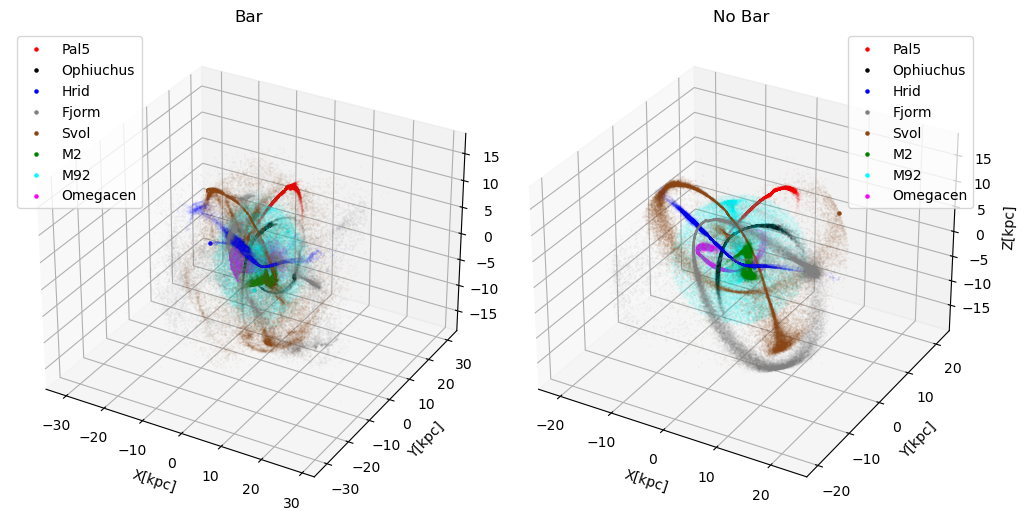

In [40]:
# Create the figure and subplots
fig = plt.figure(figsize=(10,6))

# BAR
ax1 = fig.add_subplot(121, projection='3d')

ax1.set_title('Bar')
ax1.set_xlabel('X[kpc]')
ax1.set_ylabel('Y[kpc]')
ax1.set_zlabel('Z[kpc]')

# Plot the data in the first subplot
ax1.scatter(pal5_stream_bar.x.value[0], pal5_stream_bar.y.value[0], pal5_stream_bar.z.value[0], c='red', label='Pal5', s=5)
ax1.scatter(pal5_stream_bar.x.value, pal5_stream_bar.y.value, pal5_stream_bar.z.value, c='red', s=0.001)

ax1.scatter(ophiuchus_stream_bar2.x.value[0], ophiuchus_stream_bar2.y.value[0], ophiuchus_stream_bar2.z.value[0], c='black', label='Ophiuchus', s=5)
ax1.scatter(ophiuchus_stream_bar2.x.value, ophiuchus_stream_bar2.y.value, ophiuchus_stream_bar2.z.value, c='black', s=0.001)

ax1.scatter(hrid_stream_bar.x.value[0], hrid_stream_bar.y.value[0], hrid_stream_bar.z.value[0], c='blue', label='Hrid', s=5)
ax1.scatter(hrid_stream_bar.x.value, hrid_stream_bar.y.value, hrid_stream_bar.z.value, c='blue', s=0.001)

ax1.scatter(fjorm_stream_bar.x.value[0], fjorm_stream_bar.y.value[0], fjorm_stream_bar.z.value[0], c='grey', label='Fjorm', s=5)
ax1.scatter(fjorm_stream_bar.x.value, fjorm_stream_bar.y.value, fjorm_stream_bar.z.value, c='grey', s=0.001)

ax1.scatter(svol_stream_bar.x.value[0], svol_stream_bar.y.value[0], svol_stream_bar.z.value[0], c='saddlebrown', label='Svol', s=5)
ax1.scatter(svol_stream_bar.x.value, svol_stream_bar.y.value, svol_stream_bar.z.value, c='saddlebrown', s=0.001)

ax1.scatter(m2_stream_bar2.x.value[0], m2_stream_bar2.y.value[0], m2_stream_bar2.z.value[0], c='green', label='M2', s=5)
ax1.scatter(m2_stream_bar2.x.value, m2_stream_bar2.y.value, m2_stream_bar2.z.value, c='green', s=0.001)

ax1.scatter(m92_stream_bar.x.value[0], m92_stream_bar.y.value[0], m92_stream_bar.z.value[0], c='cyan', label='M92', s=5)
ax1.scatter(m92_stream_bar.x.value, m92_stream_bar.y.value, m92_stream_bar.z.value, c='cyan', s=0.001)

ax1.scatter(omegacen_stream_bar.x.value[0], omegacen_stream_bar.y.value[0], omegacen_stream_bar.z.value[0], c='magenta', label='Omegacen', s=5)
ax1.scatter(omegacen_stream_bar.x.value, omegacen_stream_bar.y.value, omegacen_stream_bar.z.value, c='magenta', s=0.001)

ax1.legend()


# NO BAR
ax2 = fig.add_subplot(122, projection='3d')

ax2.set_title('No Bar')
ax2.set_xlabel('X[kpc]')
ax2.set_ylabel('Y[kpc]')
ax2.set_zlabel('Z[kpc]')

# Plot the data in the second subplot
ax2.scatter(pal5_stream_nobar.x.value[0], pal5_stream_nobar.y.value[0], pal5_stream_nobar.z.value[0], c='red', label='Pal5', s=5)
ax2.scatter(pal5_stream_nobar.x.value, pal5_stream_nobar.y.value, pal5_stream_nobar.z.value, c='red', s=0.001)

ax2.scatter(ophiuchus_stream_nobar2.x.value[0], ophiuchus_stream_nobar2.y.value[0], ophiuchus_stream_nobar2.z.value[0], c='black', label='Ophiuchus', s=5)
ax2.scatter(ophiuchus_stream_nobar2.x.value, ophiuchus_stream_nobar2.y.value, ophiuchus_stream_nobar2.z.value, c='black', s=0.001)

ax2.scatter(hrid_stream_nobar.x.value[0], hrid_stream_nobar.y.value[0], hrid_stream_nobar.z.value[0], c='blue', label='Hrid', s=5)
ax2.scatter(hrid_stream_nobar.x.value, hrid_stream_nobar.y.value, hrid_stream_nobar.z.value, c='blue', s=0.001)

ax2.scatter(fjorm_stream_nobar.x.value[0], fjorm_stream_nobar.y.value[0], fjorm_stream_nobar.z.value[0], c='grey', label='Fjorm', s=5)
ax2.scatter(fjorm_stream_nobar.x.value, fjorm_stream_nobar.y.value, fjorm_stream_nobar.z.value, c='grey', s=0.001)

ax2.scatter(svol_stream_nobar.x.value[0], svol_stream_nobar.y.value[0], svol_stream_nobar.z.value[0], c='saddlebrown', label='Svol', s=5)
ax2.scatter(svol_stream_nobar.x.value, svol_stream_nobar.y.value, svol_stream_nobar.z.value, c='saddlebrown', s=0.001)

ax2.scatter(m2_stream_nobar2.x.value[0], m2_stream_nobar2.y.value[0], m2_stream_nobar2.z.value[0], c='green', label='M2', s=5)
ax2.scatter(m2_stream_nobar2.x.value, m2_stream_nobar2.y.value, m2_stream_nobar2.z.value, c='green', s=0.001)

ax2.scatter(m92_stream_nobar.x.value[0], m92_stream_nobar.y.value[0], m92_stream_nobar.z.value[0], c='cyan', label='M92', s=5)
ax2.scatter(m92_stream_nobar.x.value, m92_stream_nobar.y.value, m92_stream_nobar.z.value, c='cyan', s=0.001)

ax2.scatter(omegacen_stream_nobar.x.value[0], omegacen_stream_nobar.y.value[0], omegacen_stream_nobar.z.value[0], c='magenta', label='Omegacen', s=5)
ax2.scatter(omegacen_stream_nobar.x.value, omegacen_stream_nobar.y.value, omegacen_stream_nobar.z.value, c='magenta', s=0.001)

ax2.legend()


# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()




#ax.set_title('Orbits of 7 chosen streams using a constant progenitor mass and integration time')